In [2]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
## Data Source: https://www.kaggle.com/manjeetsingh/retaildataset
# read the ['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv'] from the /data folder
import os
print("current directory is : " + os.getcwd()) 
print('the /data folder contains:') 
print(os.listdir("./data"))

stores = pd.read_csv('./data/stores data-set.csv')
features = pd.read_csv('./data/Features data set.csv')
sales = pd.read_csv('./data/sales data-set.csv')

current directory is : C:\Users\User\projects\retail_kaggle
the /data folder contains:
['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']


In [4]:
## I don't intend to use so instead of replacing na-s with 0 I better drop them all
markdown_cols = features.filter(like='MarkDown').columns
for column in markdown_cols:
     features = features.drop(column,axis=1)

# On features Fill na gaps forward on CPI and Unemployment, Data seems sorted by date already
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
features['CPI'] = features['CPI'].fillna(method='pad')
features['Unemployment'] = features['Unemployment'].fillna(method='pad')

In [5]:
# merge left all tables, use only keys from left frame, similar to a SQL left outer join; preserve key order.
    
retail = pd.merge(sales, features, how = 'left', on = ['Store', 'Date', 'IsHoliday'])
retail = pd.merge(retail, stores, how = 'left', on = ['Store'])

# format date in datetime, we need it to extract Year and Year week later to split the data in train, test
retail['Date'] = pd.to_datetime(retail['Date'])
retail['Year'] = pd.DatetimeIndex(retail['Date']).year
retail['Month'] = pd.DatetimeIndex(retail['Date']).month

retail['Year-Week'] = retail['Date'].dt.strftime('%Y-%U')

# I noticed there are Sales figures that are negative, cleanup:
retail = retail[retail['Weekly_Sales']>=0]

# turn IsHoliday into an Integer, useful later for numeric computations
retail['IsHoliday'] = retail['IsHoliday'].astype(int)

# Sort by Date as the data is not ordered by Date
retail = retail.sort_values(by=['Date'])

# checkout the dataset we're going to use further
retail.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month
count,420285.000000,420285.000000,420285.000000,420285.00000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,0.07034,60.090474,3.360888,171.212152,7.960077,136749.569176,2010.968443,6.478501
std,12.787213,30.507197,22728.500149,0.25572,18.448260,0.458523,39.162280,1.863873,60992.688568,0.796893,3.324688
min,1.000000,1.000000,0.000000,0.00000,-2.060000,2.472000,126.064000,3.879000,34875.000000,2010.000000,1.000000
25%,11.000000,18.000000,2117.560000,0.00000,46.680000,2.933000,132.022667,6.891000,93638.000000,2010.000000,4.000000
50%,22.000000,37.000000,7659.090000,0.00000,62.090000,3.452000,182.350989,7.866000,140167.000000,2011.000000,6.000000
75%,33.000000,74.000000,20268.380000,0.00000,74.280000,3.738000,212.445487,8.567000,202505.000000,2012.000000,9.000000
max,45.000000,99.000000,693099.360000,1.00000,100.140000,4.468000,227.232807,14.313000,219622.000000,2012.000000,12.000000


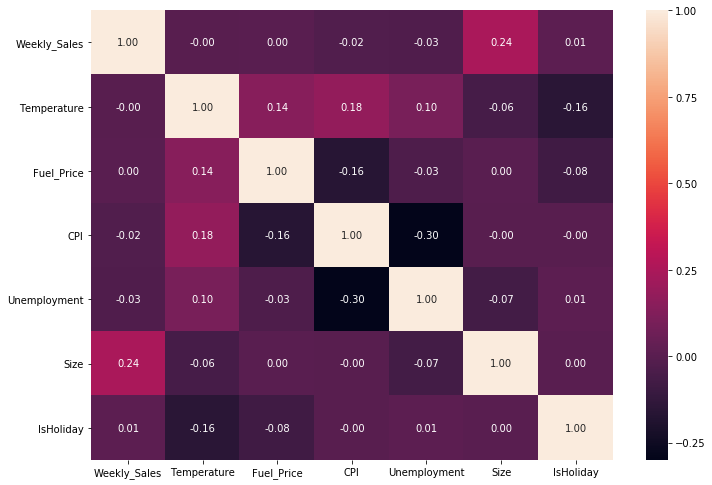

In [7]:
# Corelation analysis
# Data analysis: visualisations, corr matrix for the numeric factors for 
col_features = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df = retail[col_features]
sns.heatmap(df.corr(),annot=True,  fmt='.2f')

In [11]:
# Detecting colinearity with Eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(df.corr())

In [12]:
#Eigenvalues significance 
# Small (near 0,) means presence of colinearity (problem)
pd.Series(eigenvalues).sort_values()

0    0.514384
4    0.746681
6    0.896922
5    0.987560
3    1.219796
2    1.295019
1    1.339638
dtype: float64

In [16]:
#Eigenvectors significance
# highest values means highest loading meaning it contributes the most to the low eigenvalue
np.abs(pd.Series(eigenvectors[:,4])).sort_values(ascending=False)
print(df.columns[5], df.columns[0], df.columns[4])

Size Weekly_Sales Unemployment


In [7]:
# Multiple regression
#https://www.udemy.com/machine-learning-course-with-python/learn/v4/t/lecture/8454680?start=32
#https://www.statsmodels.org/stable/regression.html
# linear regression with multiple factors
X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col] 

# Split the data in train test using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
model =  LinearRegression()
model.fit(X,y)
result = pd.concat([pd.DataFrame(X.columns, columns=['name']),
                          pd.DataFrame(np.transpose(model.coef_), columns=['coefficient'])], axis = 1).set_index('name')
np.abs(result).sort_values(by='coefficient', ascending=False)

In [62]:
# Mean Squered error (MSE) best value is 0
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X)
print(mean_squared_error(y, y_pred))

485111395.81834054


In [67]:
########### Scale Features, I see it doesn't work right ############################
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler =  StandardScaler()
Stand_coef_linear_reg = make_pipeline(scaler,model)

In [71]:
Stand_coef_linear_reg.fit(X,y)
result1 = pd.concat([pd.DataFrame(X.columns, columns=['name']),
                          pd.DataFrame(np.transpose(Stand_coef_linear_reg.steps[1][1].coef_), columns=['coefficient'])], axis = 1).set_index('name')
np.abs(result).sort_values(by='coefficient', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


,coefficient
name,
Size,5543.157402
CPI,737.982872
Temperature,538.347190
Unemployment,492.385085
IsHoliday,359.419118
Fuel_Price,205.133006


In [66]:
# Mean Squered error (MSE) best value is 0
from sklearn.metrics import mean_squared_error
y_pred = Stand_coef_linear_reg.predict(X)
print(mean_squared_error(y, y_pred))

485111395.8183406


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [69]:
Stand_coef_linear_reg

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [72]:
Stand_coef_linear_reg.steps[1][1].coef_

array([[ 538.34718962, -205.13300554, -737.98287154, -492.38508525,
        5543.15740225,  359.41911825]])

In [75]:
## R squared multiple regression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [86]:
linear_reg = smf.ols(formula = 'Weekly_Sales ~ Temperature + Fuel_Price + CPI + Unemployment + Size + IsHoliday', data =retail )

0.06084811814338309

In [87]:
linear_reg = smf.ols(formula = 'Weekly_Sales ~ Temperature + CPI + Size', data =retail )
benchmark = linear_reg.fit()
r2_score(y, benchmark.predict(df))

0.06024035831819308